<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/AMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Importing the dataset***

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')

In [5]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if snr >=0 and (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 80000 signal vectors into X(80000, 2, 128) and their corresponding labels into labels(80000, 2)


In [6]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
snrList = [str(2*i) for i in range(10)] 
snr = snrList[9]
numberOfEachExamples = 1000

In [0]:
X = X.reshape([X.shape[0],256])
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [0]:
X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

In [0]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
# X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)


In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

***Making model***

In [0]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
dout = 0.1
classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [17]:
batch = 10
epoch = 25
classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Epoch 1/25
6400/6400 [==============================] - 1s 225us/step - loss: 1.7998 - acc: 0.2745
Epoch 2/25
6400/6400 [==============================] - 1s 172us/step - loss: 1.4987 - acc: 0.3847
Epoch 3/25
6400/6400 [==============================] - 1s 172us/step - loss: 1.3839 - acc: 0.4297
Epoch 4/25
6400/6400 [==============================] - 1s 174us/step - loss: 1.3183 - acc: 0.4506
Epoch 5/25
6400/6400 [==============================] - 1s 171us/step - loss: 1.2557 - acc: 0.4798
Epoch 6/25
6400/6400 [==============================] - 1s 171us/step - loss: 1.2134 - acc: 0.5084
Epoch 7/25
6400/6400 [==============================] - 1s 170us/step - loss: 1.1643 - acc: 0.5230
Epoch 8/25
6400/6400 [==============================] - 1s 171us/step - loss: 1.1309 - acc: 0.5377
Epoch 9/25
6400/6400 [==============================] - 1s 173us/step - loss: 1.0873 - acc: 0.5542
Epoch 10/25
6400/6400 [==============================] - 1s 172us/step - loss: 1.0465 - acc: 0.5791
Epoch 11/

In [19]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)

6400/6400 [==============================] - 0s 25us/step
Acc Test :  0.459375
Acc Train :  0.87375


***Plot Confusion Matrix***

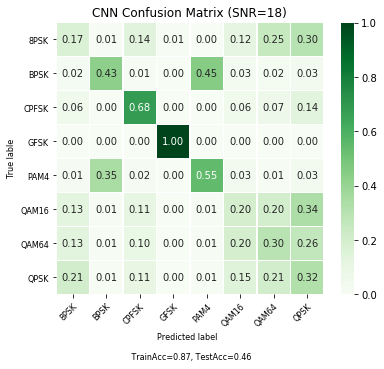

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, fmt='.2f',linewidths=.5, cmap="Greens")

plt.title(f"CNN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()

In [37]:
dic = "/content/drive/My Drive/Colab Notebooks/"
fig.savefig(dic+f"ANN2-CrossVal-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
print("Plot Saved!")

Plot Saved!
